# Convolutional Neural Network for Music Sign Classification with TensorFlow

In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import dataset

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

## Configuration and Hyperparameters

In [2]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 1

# image dimensions (only squares for now)
img_size = 70

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['accent', 'altoClef','bassClef','flat','naturals','notes4th','notes8th','noteshalf','rest8th','rest16th','rests4th','sharps','trebleClef']
num_classes = len(classes)

# batch size
batch_size = 32

# validation and test split
validation_size = 0.15
test_size = 0.15

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

seed = 230

all_path = 'data/all/'
train_path = 'data/train/'
test_path = 'data/test/'
checkpoint_dir = "models/"

## Split and Load Data

In [3]:
# run only if first time
#split_data_set(all_path, train_path, test_path, classes, validation_size=validation_size, test_size=test_size, seed=seed)

# read data sets
data = dataset.read_train_sets(train_path, img_size, classes, validation_size, seed)
test_images, test_ids = dataset.read_test_set(test_path, img_size, classes, seed)

Reading training images
Loading accent files (Index: 0)
Loading altoClef files (Index: 1)
Loading bassClef files (Index: 2)
Loading flat files (Index: 3)
Loading naturals files (Index: 4)
Loading notes4th files (Index: 5)
Loading notes8th files (Index: 6)
Loading noteshalf files (Index: 7)
Loading rest8th files (Index: 8)
Loading rest16th files (Index: 9)
Loading rests4th files (Index: 10)
Loading sharps files (Index: 11)
Loading trebleClef files (Index: 12)
Reading test images
Loading accent files (Index: 0)
Loading altoClef files (Index: 1)
Loading bassClef files (Index: 2)
Loading flat files (Index: 3)
Loading naturals files (Index: 4)
Loading notes4th files (Index: 5)
Loading notes8th files (Index: 6)
Loading noteshalf files (Index: 7)
Loading rest8th files (Index: 8)
Loading rest16th files (Index: 9)
Loading rests4th files (Index: 10)
Loading sharps files (Index: 11)
Loading trebleClef files (Index: 12)


In [4]:
#plt.imshow(test_images[123])
#print(test_ids[123])
print(data.train.images[1].shape)
print(test_images[123].shape)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

(70, 70)
(70, 70)
Size of:
- Training-set:		5859
- Test-set:		1208
- Validation-set:	1033


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i],cmap='gray')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

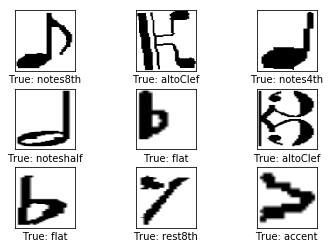

In [95]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [8]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

In [9]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights

### Helper-function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [10]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 2-dim tensor of shape `[num_images, num_inputs]`. The output is a 2-dim tensor of shape `[num_images, num_outputs]`.

In [11]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

### Convolutional Layers

In [16]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [22]:
layer_flat, num_features = flatten_layer(layer_conv3)
num_features

### Fully-Connected Layers

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

### Predicted Class

In [29]:
y_pred = tf.nn.softmax(layer_fc2)

The class-number is the index of the largest element.

In [30]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [34]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [36]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

In [38]:
train_batch_size = batch_size

In [39]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [40]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [41]:
def plot_example_errors(cls_pred, correct):
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [42]:
def plot_confusion_matrix(cls_pred):

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

### Helper-function for showing the performance

In [43]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)
        
        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(j-i, img_size_flat)
   
        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 1 optimization iteration

In [44]:
optimize(num_iterations=1)
print_validation_accuracy()

Epoch 1 --- Training Accuracy:   6.2%, Validation Accuracy:  21.9%, Validation Loss: 2.490
Time elapsed: 0:00:01
Accuracy on Test-Set: 11.9% (123 / 1033)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [45]:
optimize(num_iterations=99)  # We already performed 1 iteration above.

Time elapsed: 0:00:45


Accuracy on Test-Set: 41.8% (432 / 1033)
Example errors:


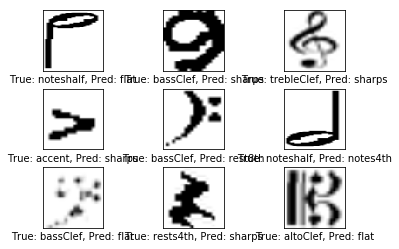

In [46]:
print_validation_accuracy(show_example_errors=True)

## Performance after 500 optimization iterations

In [47]:
optimize(num_iterations=400)  # We performed 100 iterations above.

Epoch 2 --- Training Accuracy:  78.1%, Validation Accuracy:  87.5%, Validation Loss: 0.704
Epoch 3 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.494
Time elapsed: 0:03:03


Accuracy on Test-Set: 94.5% (976 / 1033)
Example errors:


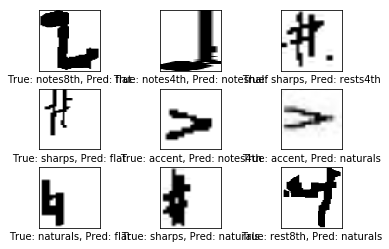

In [48]:
print_validation_accuracy(show_example_errors=True)

## Test on Sample Image

(70, 70)


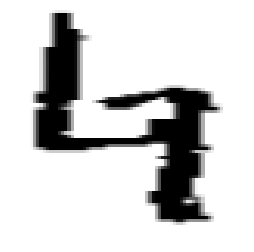

In [64]:
plt.axis('off')

test_natural = cv2.imread('naturals.png',0)
test_natural = cv2.resize(test_natural, (img_size, img_size), cv2.INTER_LINEAR) / 255

print(test_natural.shape)

preview_natural = plt.imshow(test_natural, cmap='gray')

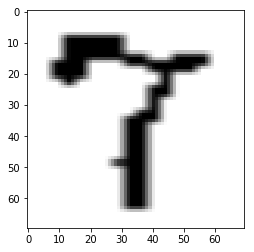

In [65]:
test_rest8th = cv2.imread('rest8th.png',0)
test_rest8th = cv2.resize(test_rest8th, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_rest8th = plt.imshow(test_rest8th, cmap='gray')

In [66]:
def sample_prediction(test_im, label):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: [np.eye(len(classes))[classes.index(label)]]
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

print("Predicted class for test_natural: {}".format(sample_prediction(test_natural,"naturals")))
print("Predicted class for test_rest8th: {}".format(sample_prediction(test_rest8th,"rest8th")))

Predicted class for test_natural: naturals
Predicted class for test_rest8th: rest8th


## Visualization of Weights and Layers

In trying to understand why the convolutional neural network can recognize images, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [67]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [68]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.
    
    image = image.reshape(img_size_flat)

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images

Helper-function for plotting an image.

In [71]:
def plot_image(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

Plot an image from the test-set which will be used as an example below.

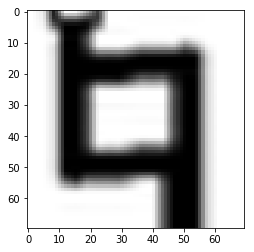

In [72]:
image1 = test_images[0]
plot_image(image1)

Plot another example image from the test-set.

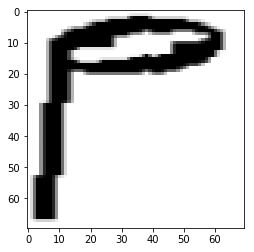

In [73]:
image2 = test_images[13]
plot_image(image2)

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

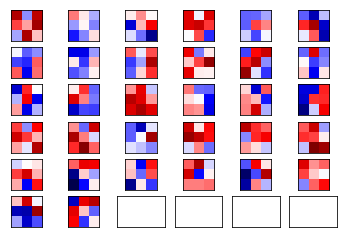

In [74]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to about half the resolution of the original input image.

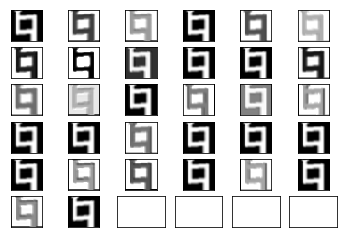

In [75]:
plot_conv_layer(layer=layer_conv1, image=image1)

The following images are the results of applying the convolutional filters to the second image.

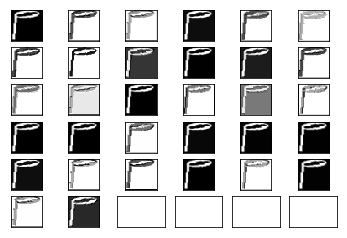

In [76]:
plot_conv_layer(layer=layer_conv1, image=image2)

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

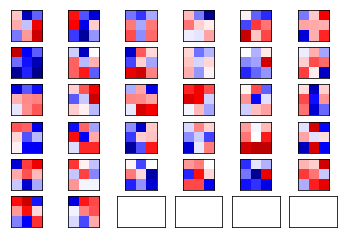

In [77]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

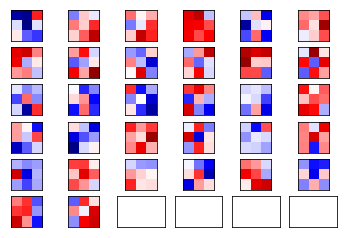

In [78]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to half the resolution of the images from the first conv-layer.

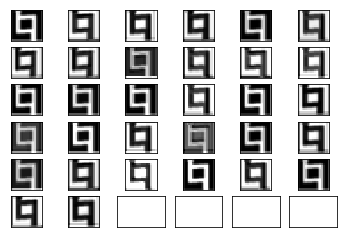

In [79]:
plot_conv_layer(layer=layer_conv2, image=image1)

And these are the results of applying the filter-weights to the second image.

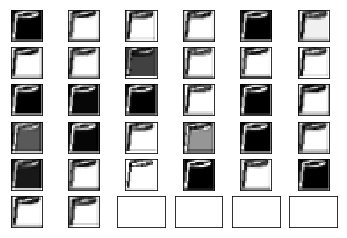

In [80]:
plot_conv_layer(layer=layer_conv2, image=image2)

### Close TensorFlow Session

In [82]:
session.close()